In [1]:
from collections import defaultdict
import os
import pandas as pd
pd.options.display.float_format = '{:>5.2f}'.format
import numpy as np

import matplotlib.pyplot as plt
import json
from pprint import pprint

from scipy.ndimage.filters import gaussian_filter1d
from lifted_embedding_estimation_with_truth_value import name2lstr

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metrics = ['mrr', 'hit1', 'hit3', 'hit10']

Conjunction_queries = ['1p', '2p', '3p', '2i', '3i', 'pi', 'ip']
Negation_queries = ['2in', '3in', 'inp', 'pin', 'pni']
Disjunction_queries = ['2u', 'up']
queries = Conjunction_queries + Disjunction_queries + Negation_queries

filter_width = .1

In [3]:
def read_log_lines(filename):
    lines = []
    with open(filename, 'rt') as f:
        for line in f.readlines():
            lines.append(line)
    return lines

def filter_lines(lines, key_str):
    rec = []
    for line in lines:
        if not key_str in line:
            continue
        json_content = json.loads(line.split(']')[-1])
        try:
            rec.append(
                json_content
            )
        except:
            print("Error in ", line)
    return rec 

In [28]:
def plot_train_lines(lines, lstr=None):
    rec = filter_lines(lines=lines, key_str="train lifted")
    if not rec:
        return
    data = defaultdict(list)
    for i, this_record in enumerate(rec):
        for k in this_record:
            data[k].append(this_record[k])
        data['id'].append(i)
    df = pd.DataFrame(data)
    
    if lstr:
        df = df[df.lstr == lstr]
        
    if len(df) > 50000:
        df = df.sample(n=50000)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

    ax1.set_xlabel('steps')
    ax1.set_ylabel('loss')
    keys = ['loss', 'acc_loss']
    for label in keys:
        if label in df:
            # ax2.plot(df['id'], df[label], alpha=0.5, label=label)
            ax1.scatter(df['id'], df[label], s=1, label=label)
            
    ax1.legend()
    ax1.set_yscale('log')
    
    keys = ['contrastive_pos_score', 'contrastive_neg_score', 'pos_nll', 'neg_nll']
    for label in keys:
        if label in df:
            # ax3.plot(df['id'], df[label], alpha=0.5, label=label)
            ax2.scatter(df['id'], df[label], s=1, label=label)
            
    ax2.legend()
    # ax3.set_ylim([0, 1])

    ax2.set_yscale('log')
    # ax2.set_yticks([1e-2, 1e-1, 1])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [5]:
def evaluation_to_tables(line, collect_metrics=metrics, verbose=True):
    data = defaultdict(list)
    for m in collect_metrics:
        data['metric'].append(m)
        for k in queries:
            if k in line:
                data[k].append(line[k][m] * 100)
        data['epoch'] = line['epoch']
    df = pd.DataFrame(data)
    try:
        df['epfo mean'] = df[Conjunction_queries + Disjunction_queries].mean(axis=1)
    except:
        pass
    try:
        df['Neg mean'] = df[Negation_queries].mean(axis=1)
    except:
        pass
    return df

def aggregate_evaluations(lines, key_str, collect_metrics=metrics, out_dir="unnamed"):
    print(key_str)
    rec_lines = filter_lines(lines, key_str)
    df_list = []
    for e, line in enumerate(rec_lines):
        df = evaluation_to_tables(line, collect_metrics)
        # print(df.to_markdown(floatfmt=".2f"))
#         df['epoch'] = (e+1) * 5
        df_list.append(df)
    if len(df_list) == 0:
        return
    final_df = pd.concat(df_list)
    final_df = final_df.set_index(['epoch', 'metric'])
    print(final_df.tail().to_string(col_space=5))
    path = os.path.join("results", out_dir, key_str + ".csv")
    os.makedirs(os.path.dirname(path), exist_ok=True)
    final_df.to_csv(path)

In [10]:
def show_trajectory(filename, metrics=['mrr']):
    out_dir = os.path.dirname(filename)
    lines = read_log_lines(filename)
    plot_train_lines(lines)
    aggregate_evaluations(lines, 'CQD evaluate valid', collect_metrics=metrics, out_dir=out_dir)
    aggregate_evaluations(lines, 'CQD evaluate test', collect_metrics=metrics, out_dir=out_dir)

    
    aggregate_evaluations(lines, 'tv evaluate valid', collect_metrics=metrics, out_dir=out_dir)
    aggregate_evaluations(lines, 'tv evaluate test', collect_metrics=metrics, out_dir=out_dir)

    aggregate_evaluations(lines, 'NN evaluate valid', collect_metrics=metrics, out_dir=out_dir)
    aggregate_evaluations(lines, 'NN evaluate test', collect_metrics=metrics, out_dir=out_dir)
    # plot_evaluation(lines)

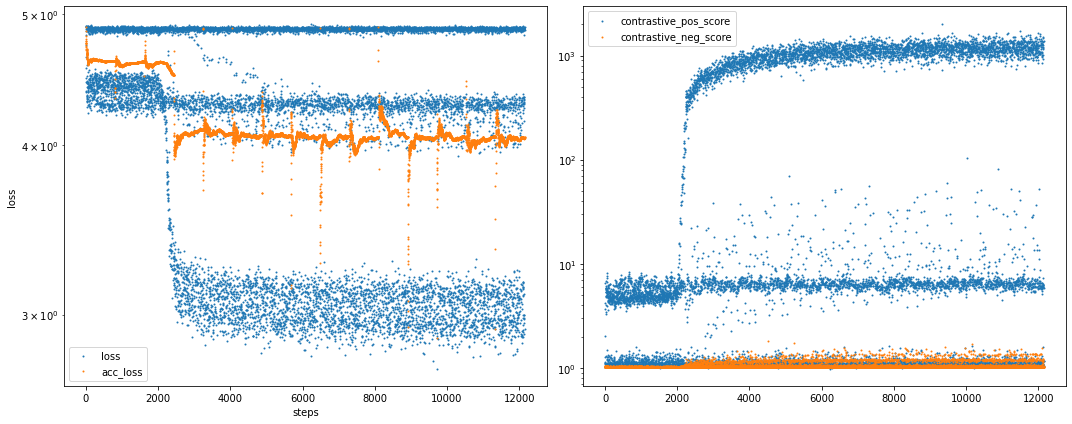

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr     4.81  3.44  3.05  0.16  0.09  2.99  3.29  0.08  2.63  0.09  0.07  3.46  1.40  0.63       2.28      1.13
9     mrr     4.81  3.65  3.10  0.16  0.09  2.98  3.37  0.08  2.79  0.09  0.07  3.88  1.42  0.99       2.34      1.29
14    mrr     4.81  3.66  3.04  0.16  0.09  3.03  3.47  0.09  2.67  0.10  0.07  3.84  1.42  1.14       2.34      1.31
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr     5.00  3.82  3.31  0.15  0.10  3.40  3.63  0.18  2.84 

In [35]:
show_trajectory('log/FB15k-237/lmpnn-rotate-temp_0.1/output.log')

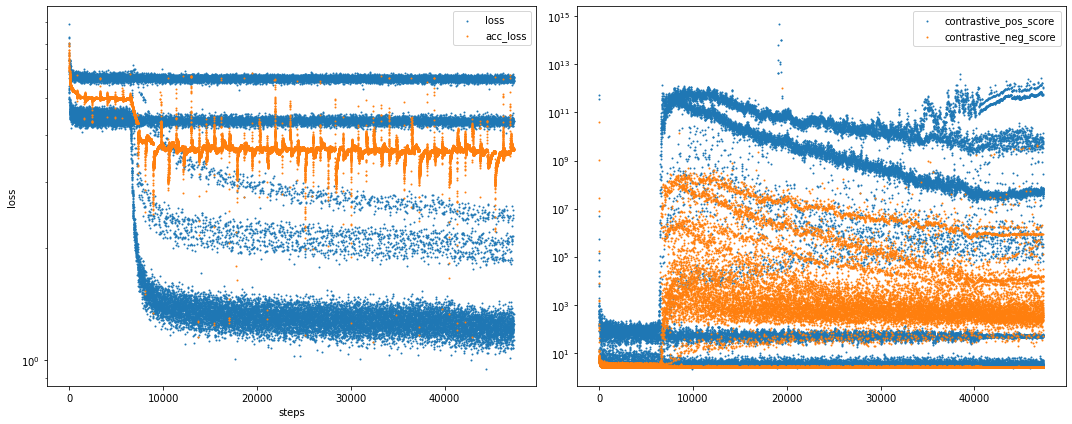

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
34    mrr     4.83  4.67  4.43  0.16  0.10  2.87  3.68  0.08  4.84  0.10  0.07  5.03  1.87  1.08       2.85      1.63
39    mrr     4.85  4.74  4.77  0.16  0.10  3.08  3.86  0.08  4.84  0.10  0.07  4.83  1.91  1.03       2.94      1.59
44    mrr     4.85  4.57  4.63  0.16  0.10  3.00  3.67  0.08  4.89  0.10  0.07  4.72  1.78  1.01       2.88      1.53
49    mrr     4.95  4.55  4.79  0.16  0.09  2.91  3.82  0.08  4.77  0.10  0.07  5.09  1.84  1.15       2.90      1.65
54    mrr     4.85  4.83  4.83  0.16  0.10  3.13  3.94  0.08  4.85  0.10  0.07  5.29  1.90  1.20       2.98      1.71
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [36]:
show_trajectory('log/FB15k-237/lmpnn-rotate-temp_0.01/output.log')

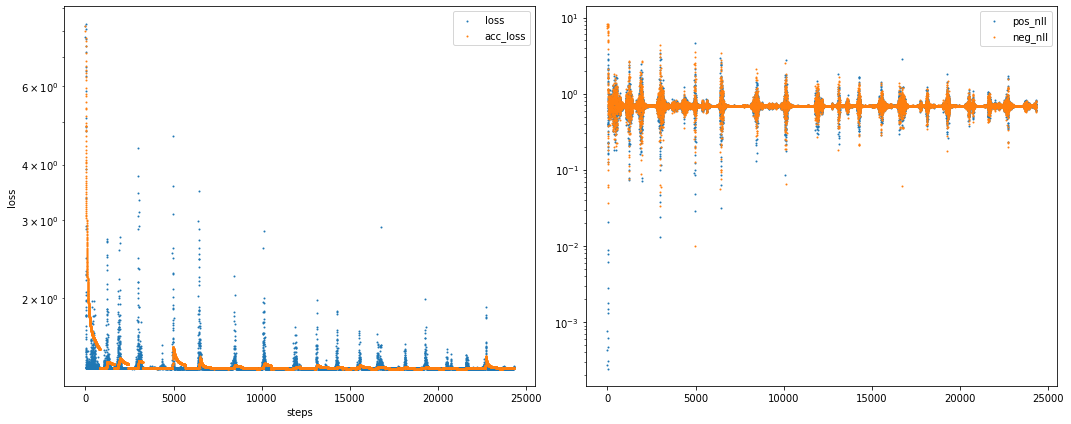

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
9     mrr     1.48  0.08  0.10  0.09  0.06  0.07  0.11  0.07  0.08  0.09  0.08  0.07  0.08  0.07       0.24      0.08
14    mrr     0.52  0.07  0.09  0.07  0.07  0.07  0.08  0.08  0.07  0.08  0.07  0.07  0.08  0.07       0.12      0.07
19    mrr     3.54  0.11  0.12  0.14  0.07  0.08  0.17  0.09  0.08  0.12  0.10  0.07  0.08  0.06       0.49      0.08
24    mrr     4.23  0.11  0.12  0.14  0.08  0.08  0.16  0.08  0.08  0.11  0.10  0.06  0.07  0.06       0.56      0.08
29    mrr     4.23  0.10  0.12  0.14  0.07  0.08  0.16  0.08  0.08  0.11  0.09  0.06  0.07  0.05       0.56      0.08
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [37]:
show_trajectory('log/FB15k-237/lmpnn-rotate-pos_neg/output.log')

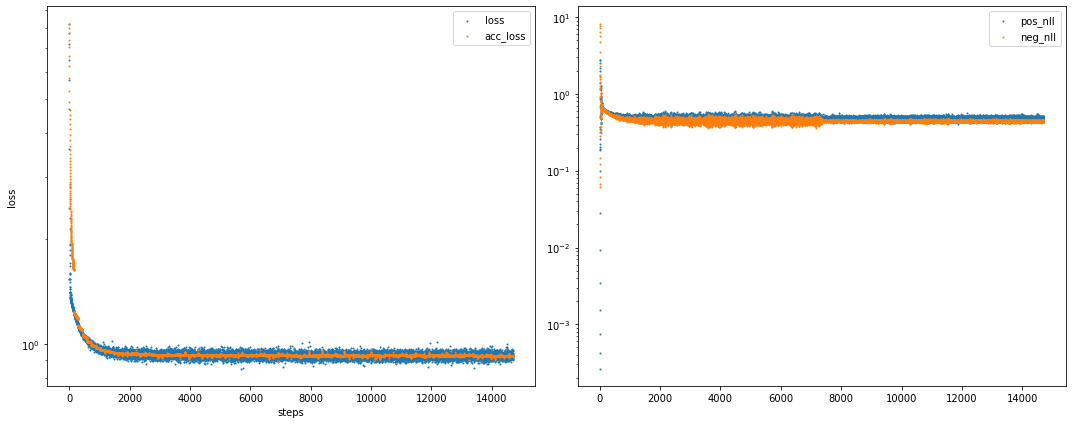

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p
epoch metric      
79    mrr     5.05
84    mrr     5.05
89    mrr     5.05
94    mrr     5.05
99    mrr     5.05
NN evaluate test
                1p
epoch metric      
79    mrr     5.24
84    mrr     5.24
89    mrr     5.24
94    mrr     5.24
99    mrr     5.24


In [42]:
show_trajectory('log/FB15k-237/lmpnn-rotate-pos_neg_test1p/output.log')